# Exercice on local approximation of an univariate quadratic expression using linear regression

Idea : 
- Perform linear regression analiticaly
- Perform linear regression with gradient descent (SGD)

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics as skMetrics
from sklearn.linear_model import LinearRegression as skLinearRegression 
import scipy as sy
import sympy
import pandas

## Generator Model

In [2]:
def generateBatch(N, stochastic = False):
    #
    xMin = 0
    xMax = 0.5
    #
    b = 0.35
    std = 0.01
    #
    if stochastic:
        x = random.uniform(xMin, xMax, N)
    else:
        x = np.linspace(xMin, xMax, N)
    yClean = x**4 + (x-0.3)**3 + b
    y =  yClean + random.normal(0, std, N) 
    return (x, y, yClean)

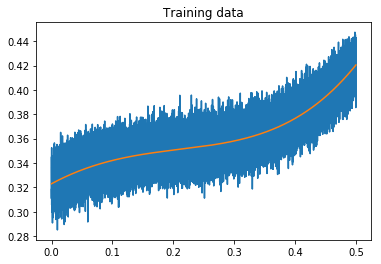

In [3]:
N = 100000
xTrain, yTrain, yClean = generateBatch(N)
plt.plot(xTrain, yTrain, xTrain, yClean);
plt.title('Training data')
xTest, yTest, yTestClean = generateBatch(N)

In [4]:
xs = sympy.Symbol('x')
sympy.expand(xs**4 + (xs-0.3)**3 + 0.35)

x**4 + x**3 - 0.9*x**2 + 0.27*x + 0.323

# Closed form / analiticaly

Remove biases

In [5]:
xUnB = xTrain - np.mean(xTrain)
yUnB = yTrain - np.mean(yTrain)

## Maison

Linear, 1st degree approximation of y:
\begin{align}
y = x w + b
\end{align}

- $x$ is a $N_{feature} * N_{sample}$ matrix 
- $w$ is a $N_{feature}$ vector
- $y$ is a $N_{sample}$ vector
- $b$ is a scalar

Let's define unbiased y:
\begin{align}
y_u = y - b = x w
\end{align}

Using mean square error (Euclidian norm), we are looking for $w_{est}$ such that:


\begin{align}
w_{est} = min_w \lVert x w - y_u \rVert_2^2
\end{align}

\begin{align}
L_2(w) & = \lVert x w - y_u \rVert_2^2 = (x w - y_u)^T(x w - y_u) \\
& = w^T x^T x w + y_u^T y_u - 2 x^T w^T y_u
\end{align}

Lookup the minimum through the partial derivate:

$$\frac{\partial{L_2(w)}}{\partial w} = 2 x^T x w - 2 x^T  y_u$$

If $x^T x$ can be inverted:
$$\frac{\partial{L_2(w)}}{\partial w} = 0 \iff w = (x^T x)^{-1} x^T y_u$$

In [6]:
# In case x is univariate, the matrix product x^T x is a scalar
xTxInv = 1/np.matmul(xUnB.T,xUnB)
w = xTxInv * np.matmul(xUnB.T, yUnB)
w

0.14501892725026932

In [7]:
bEst = np.mean(yTrain - w * xTrain)
bEst

0.32299617292195776

In [8]:
yEst1 = w*xTest + bEst

Closed form, MSE = 1.489e-04


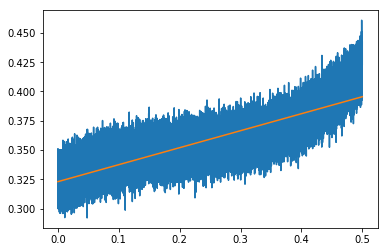

In [9]:
plt.plot(xTest, yTest, xTest, yEst1);
mse1 = np.dot(yTest-yEst1, yTest-yEst1) / N
print('Closed form, MSE =', "{:.3e}".format(mse1));

## Numpy polyfit, 1s degree
http://www.python-simple.com/python-numpy-scipy/fitting-regression.php

In [10]:
fit2 = np.polyfit(xTrain, yTrain, 1)
fit2

array([0.14501893, 0.32299617])

In [11]:
yEst2 = fit2[0] * xTest + fit2[1]

Numpy polyfit 1st degree, MSE = 1.489e-04


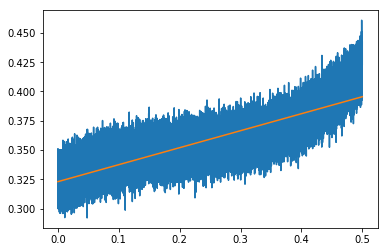

In [12]:
plt.plot(xTest, yTest, xTest, yEst2);
mse2 = skMetrics.mean_squared_error(yTest, yEst2)
print('Numpy polyfit 1st degree, MSE =', "{:.3e}".format(mse2));

## Numpy polyfit, 4th degree

In [13]:
fit3 = np.polyfit(xTrain, yTrain, 4)
fit3

array([ 1.01623428,  0.9793974 , -0.89047566,  0.26826742,  0.32308113])

In [14]:
yEst3 = xTest**4 * fit3[0] + xTest**3 * fit3[1] + xTest**2 * fit3[2] + xTest * fit3[3] + fit3[4]

Numpy polyfit 4th degre, MSE = 9.963e-05


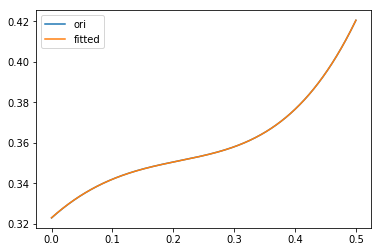

In [15]:
plt.plot(xTest, yTestClean, xTest, yEst3);
mse3 = skMetrics.mean_squared_error(yTest, yEst3)
plt.legend(['ori','fitted'])
print('Numpy polyfit 4th degre, MSE =', "{:.3e}".format(mse3));

## NumPy least square
http://www.python-simple.com/python-numpy-scipy/fitting-regression.php

In [16]:
fit4, residues, rank, s = np.linalg.lstsq(np.reshape(xUnB, (N,1)), yUnB)
fit4

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


array([0.14501893])

In [17]:
yEst4 = fit4 * xTest + bEst

Numpy Least square, MSE = 1.489e-04


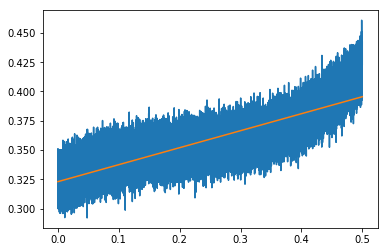

In [18]:
plt.plot(xTest, yTest, xTest, yEst4);
mse4 = skMetrics.mean_squared_error(yTest, yEst4)
print('Numpy Least square, MSE =', "{:.3e}".format(mse4));

## Scipy linear regression

http://www.python-simple.com/python-numpy-scipy/fitting-regression.php

In [19]:
fit5 = sy.stats.linregress(xTrain, yTrain)
fit5

LinregressResult(slope=0.14501892725026938, intercept=0.32299617292195787, rvalue=0.8634025360218429, pvalue=0.0, stderr=0.0002679725880027204)

In [20]:
yEst5 = fit5.slope * xTest + fit5.intercept

Scipy, MSE = 1.489e-04


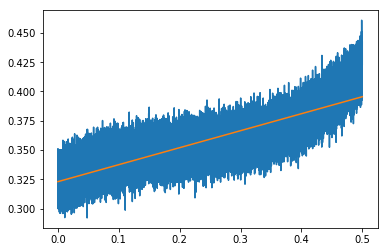

In [21]:
plt.plot(xTest, yTest, xTest, yEst5)
mse5 = skMetrics.mean_squared_error(yTest, yEst5)
print('Scipy, MSE =', "{:.3e}".format(mse5));

## SK Learn linear regression

In [22]:
model6 = skLinearRegression(normalize=False)
model6.fit(xTrain.reshape(-1,1), yTrain.reshape(-1,1))
print('SciKit Learn linear regression, b =', model6.intercept_, ', w =', model6.coef_)

SciKit Learn linear regression, b = [0.32299617] , w = [[0.14501893]]


In [23]:
print('SciKit Learn, R^2-score =', model6.score(xTest.reshape(-1,1), yTest))

SciKit Learn, R^2-score = 0.746163589457299


In [24]:
yEst6 = model6.predict(xTest.reshape(-1,1))

SciKit Learn, MSE = 1.489e-04


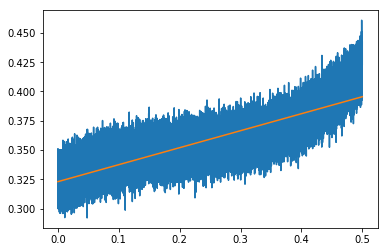

In [25]:
plt.plot(xTest, yTest, xTest, yEst6)
mse6 = skMetrics.mean_squared_error(yTest, yEst6)
print('SciKit Learn, MSE =', "{:.3e}".format(mse6));

# Gradient descent

Plot MSE for several values of the slope

In [26]:
Ns = 100
slope = np.linspace(-1, 1, Ns)
sx = np.matmul(np.reshape(xUnB, (N, 1)), np.reshape(slope,(1,Ns)))
er_sx_y = sx - np.reshape(yUnB, (N, 1)) 
mse = np.mean(er_sx_y.T**2, axis = 1)

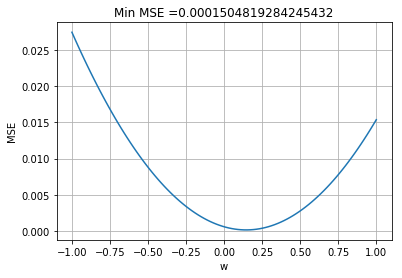

In [27]:
plt.plot(slope, mse)
plt.xlabel('w')
plt.ylabel('MSE')
plt.title('Min MSE =' + str(np.min(mse)))
plt.grid();

Convexity of the MSE as function of the linear regression slope (w coefficient) is demonstrated

### Gradient descent

In [28]:
# Initial coef
w7 = 2
threshold = 1e-7
# learningRate = 0.0009 # Aggresive
learningRate = 0.0005 # Quick
# learningRate = 0.0001
gradient = np.matmul(xUnB.T, w7*xUnB - yUnB)
gradientNorm = gradient**2 # univariate
print('w start =', w7, ', Gradient norm =', gradientNorm)
w7Learn = [np.array([w7, gradientNorm])]
while gradientNorm > threshold:
#for i in range(10):
    w7 = w7 - learningRate * gradient
    gradient = np.matmul(xUnB.T, w7*xUnB - yUnB) 
    gradientNorm = gradient**2
    #print('w =', w7, ', Gradient norm =', gradientNorm)
    w7Learn.append(np.array([w7,  gradientNorm]))
print('w end =', w7, ', Gradient norm =', gradientNorm, ', num iteration =', len(w7Learn))
df7 = pandas.DataFrame(w7Learn, columns = ('w', 'Gradient norm'))

w start = 2 , Gradient norm = 14935296.967030186
w end = 0.14501893698613558 , Gradient norm = 4.114187721827837e-10 , num iteration = 7


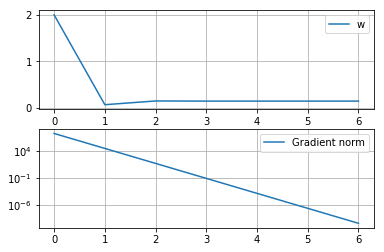

In [29]:
plt.subplot(2,1,1)
plt.plot(df7['w'])
plt.grid()
plt.legend();
plt.subplot(2,1,2)
plt.semilogy(df7['Gradient norm'])
plt.grid()
plt.legend();

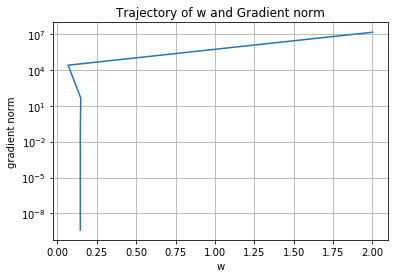

In [30]:
plt.semilogy(df7['w'], df7['Gradient norm'])
plt.grid()
plt.xlabel('w')
plt.ylabel('gradient norm');
plt.title('Trajectory of w and Gradient norm');

In [31]:
yEst7 = w7*xTest + bEst

Gradient descent, MSE = 1.489e-04


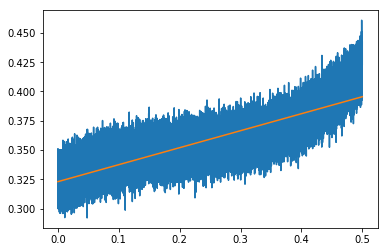

In [32]:
plt.plot(xTest, yTest, xTest, yEst7);
mse7 = skMetrics.mean_squared_error(yTest, yEst7)
print('Gradient descent, MSE =', '{:.3e}'.format(mse7));

## Stochastic gradient descent

Using new data at each iteration.

Alternatively, on a finite data set, shuffle the samples.

In [33]:
def calcGradient(x, y, w):
    _x = x - np.mean(x)
    _y = y - np.mean(y)
    gradient = np.matmul(_x.T, (w*_x - _y))
    return gradient

In [34]:
Nbatch = 100
w8 = 10
threshold = 1e-7
learningRate = 0.05
# Initial batch
xBatch, yBatch, yBC = generateBatch(Nbatch, True)
gradient = calcGradient(xBatch, yBatch, w8)
gradientNorm = gradient**2 # univariate
print('w start =', w8, ', Gradient norm =', gradientNorm)
w8Learn = [np.array([w8, gradientNorm])]
# Continue
while gradientNorm > threshold:
    w8 = w8 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(Nbatch, True)
    gradient = calcGradient(xBatch, yBatch, w8)
    gradientNorm = gradient**2
    w8Learn.append(np.array([w7,  gradientNorm]))
    learningRate = learningRate * 0.99
print('w end =', w8, ', Gradient norm =', gradientNorm, ', num iteration =', len(w8Learn))
df8 = pandas.DataFrame(w8Learn, columns = ('w', 'Gradient norm'))

w start = 10 , Gradient norm = 466.391463032005
w end = 0.1484019457800095 , Gradient norm = 2.4657489318128916e-08 , num iteration = 175


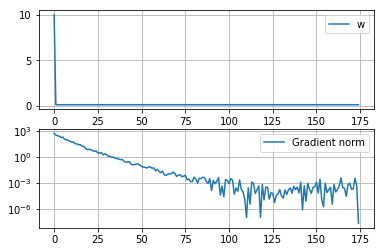

In [35]:
plt.subplot(2,1,1)
plt.plot(df8['w'])
plt.grid()
plt.legend();
plt.subplot(2,1,2)
plt.semilogy(df8['Gradient norm'])
plt.grid()
plt.legend();

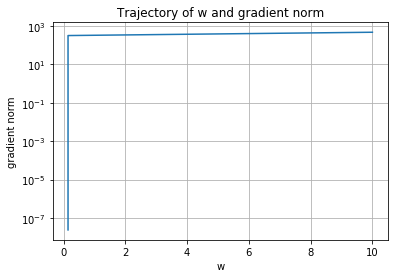

In [36]:
plt.semilogy(df8['w'], df8['Gradient norm'])
plt.xlabel('w')
plt.ylabel('gradient norm')
plt.title('Trajectory of w and gradient norm')
plt.grid();

In [37]:
yEst8 = w8*xTest + bEst

Stochastic gradient descent, MSE = 1.498e-04


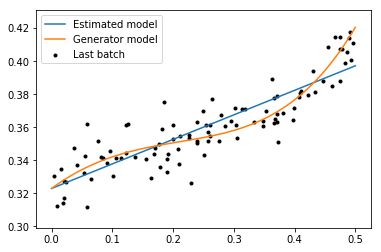

In [38]:
plt.scatter(xBatch, yBatch, marker='.', color = 'black');
plt.plot(xTest, yEst8)
plt.plot(xTrain, yClean)
plt.legend(['Estimated model', 'Generator model', 'Last batch'])
mse8 = skMetrics.mean_squared_error(yTest, yEst8) 
print('Stochastic gradient descent, MSE =', "{:.3e}".format(mse8));